In [102]:
import torch
import pandas as pd
import json
from sklearn.cluster import KMeans
import sys
import os
from os import environ
sys.path.append("./")
sys.path.append("../")
from dataclasses import dataclass

In [106]:
dataclass(frozen=True)
class Pathes:
    data_buildings_unom_ids_pairs: str = './data_buildings_unom_ids_pairs.json'
    tensors: str = environ.get('TENSORS_PATH')
    weather_dataset: str = environ.get('WEATHER_DATAST_PATH')
    datasets: str = environ.get('DATASETS_PATH')
    dataframes: str = environ.get('DATAFRAMES_PATH')
    columns_info: str = '../columns_info.json'
    factorizers_path: str = environ.get('FACTORIZERS_PATH')
    is_day_anomaly_model_path: str = environ.get('IS_DAY_ANOMALY_MODEL_PATH')
    what_anomaly_in_day_model_path: str = environ.get('WHAT_ANOMALY_IN_DAY_MODEL_PATH')
    weathers_tensors: str = environ.get('WEATHERS_TENSORS')

In [107]:
list_of_dataframes = os.listdir('../dataframes/')

In [108]:
with open(Pathes.columns_info) as f:
    d = json.load(f)
    @dataclass(frozen=True)
    class ColumnsInfo:
        building_column_for_model = d['building_column_for_model']
        scale_data = d['columns_scale_data']
        usless_col = d['useless_columns']
        useless_by_classification = d['useless_by_classification']
        categorical_columns = d['categorical_columns']
        usfull_columns_in_buildings_data = d['usfull_columns_for_algorithms']['usfull_columns_in_buildings_data']
        usfull_columns_in_anomaly_ts = d['usfull_columns_for_algorithms']['usefull_columns_in_anomaly_ts']
        time_columns = d['time_columns']
        usefull_events = d["usefull_events"]
        columns_norm_forms = d['columns_norm_form_pairs']
        weathers_types = d['weathers_types']
        buildings_dataframe_columns = d['buildings_dataframe_columns']
        heat_station_columns = d['heat_station_usefull_columns']

In [109]:
import numpy as np
from tqdm import tqdm

In [110]:
def get_buildings_dataset(dfs: list[pd.DataFrame]) -> pd.DataFrame | None:
    list_of_cleaned_dataframe: list[pd.DataFrame] = []
    for df_i in tqdm(dfs, desc='get_buildings_dataset'):
        cols_i = df_i.columns.intersection(ColumnsInfo.usfull_columns_in_buildings_data)
        list_of_cleaned_dataframe.append(df_i.loc[:, cols_i])
    if len(list_of_cleaned_dataframe):
        unom_ids = np.unique(sum([i['UNOM'].to_list() for i in list_of_cleaned_dataframe if 'UNOM' in i.columns], []))
        merged_dataframe = pd.DataFrame({'UNOM': unom_ids.astype(float).astype(int)})
        for i in tqdm(list_of_cleaned_dataframe, desc='gbd'):
            if 'UNOM' in i.columns:
                i['UNOM'] = i['UNOM'].astype(int)
                merged_dataframe = pd.merge(merged_dataframe, i, how='left', on='UNOM')
        return merged_dataframe.drop_duplicates()

In [113]:
buildings_dataset = get_buildings_dataset([pd.read_csv('../dataframes/' + i) for i in list_of_dataframes])

/tmp/ipykernel_289028/1464877657.py:1: DtypeWarning: Columns (12,14,19,22,35) have mixed types. Specify dtype option on import or set low_memory=False.
  buildings_dataset = get_buildings_dataset([pd.read_csv('../dataframes/' + i) for i in list_of_dataframes])
gbd: 100%|██████████| 8/8 [00:01<00:00,  7.27it/s]


In [114]:
print(buildings_dataset.shape)

(491633, 16)


In [115]:
buildings_dataset.dropna(thresh=9, inplace=True, axis=0)

In [125]:
buildings_dataset.loc[buildings_dataset['UNOM'] == 18989]

,UNOM,Этажность,Общая площадь_x,Центральное отопление(контур),Серии проектов,Количество этажей,Количество подъездов,Количество квартир,Общая площадь_y,Общая площадь жилых помещений,Износ объекта (по БТИ),Признак аварийности здания,Количество пассажирских лифтов,Количество грузопассажирских лифтов,Очередность уборки кровли,Материалы кровли по БТИ
468995,18989,14.0,"6415,6",ЦО1,2048764.0,14.0,2.0,110.0,6415.6,6376.0,NaN,22728486.0,4.0,0.0,NaN,22289201.0


In [ ]:
buildings_dataset = dataframe_processors.get_buildings_dataset(list_of_dataframes)
print(buildings_dataset.shape)
treshhold = len(buildings_dataset.columns)/2
# treshhold = 0
buildings_dataset.dropna(thresh=treshhold, axis=0, inplace=True)
buildings_dataset = dataframe_processors.process_buildings_dataframe(buildings_dataset)
print(buildings_dataset.shape)
unom_ids, idxes = np.unique(buildings_dataset['UNOM'], return_index=True)
unom_ids = unom_ids.tolist()
buildings_dataset = buildings_dataset.iloc[idxes]

In [33]:
weather = torch.load('../weathers_tensors/2024_in_days.pt').unsqueeze(0)

In [36]:
model1 = torch.jit.load('../models/day_anomaly_prediction_modded_2024-06-14T04:52:57.191107.pt', map_location='cpu')

In [8]:
with open('../data_buildings_unom_ids_pairs.json') as f:
    data = json.load(f)

In [14]:
bt = torch.load(f'../tensors/{data[list(data)[0]]['tensor_id']}.pt')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
c = KMeans(n_clusters=32).fit(bt).labels_
cp = dict()
for i in set(c):
    cp[i] = bt[c==i]
std_d = dict()
with torch.no_grad():
    for k, v in cp.items():
        std_d[k] = model1(weather.repeat(sum(c==k), 1, 1).float(), bt[c==k].float())

In [72]:
pd.DataFrame({i: j.std(axis=0) for i,j in cp.items()}).describe()

/tmp/ipykernel_289028/3885441925.py:1: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  pd.DataFrame({i: j.std(axis=0) for i,j in cp.items()}).describe()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
count,18.000000,18.000000,18.0,18.000000,18.000000,18.000000,18.000000,18.000000,0.0,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,0.0,18.000000,18.000000,18.000000,18.000000,18.000000
mean,0.021703,0.013841,0.0,0.037566,0.019527,0.019641,0.039055,0.020358,NaN,0.018892,0.026474,0.035824,0.069230,0.021420,0.049132,0.101800,0.046004,0.017769,0.008097,0.031636,0.032359,0.031413,0.038043,0.018468,0.023633,0.037224,NaN,0.085215,0.118634,0.014411,0.027916,0.020792
std,0.030080,0.023295,0.0,0.046109,0.030540,0.034088,0.054193,0.034123,NaN,0.029335,0.037012,0.050089,0.088701,0.030802,0.067957,0.132383,0.054879,0.026431,0.011790,0.041664,0.055255,0.043057,0.090701,0.028242,0.032914,0.050725,NaN,0.119293,0.204914,0.022199,0.039069,0.029267
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.045380,0.025887,0.0,0.076446,0.039629,0.025500,0.080670,0.033838,NaN,0.028581,0.042480,0.084543,0.142171,0.043261,0.098383,0.179396,0.105310,0.029266,0.016944,0.056628,0.061028,0.067715,0.033384,0.042182,0.049645,0.078357,NaN,0.167456,0.178390,0.027433,0.066282,0.041249
max,0.085540,0.088655,0.0,0.137057,0.109580,0.123404,0.147845,0.127132,NaN,0.088636,0.110780,0.133340,0.287947,0.101279,0.187912,0.392925,0.125282,0.087886,0.038559,0.125594,0.193289,0.110538,0.374471,0.080781,0.102179,0.136055,NaN,0.350143,0.619128,0.080064,0.111340,0.077188


In [73]:
pd.DataFrame({i: j.mean(axis=0) for i,j in cp.items()}).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
count,18.000000,1.800000e+01,18.000000,18.000000,1.800000e+01,1.800000e+01,18.000000,1.800000e+01,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,1.800000e+01,18.000000,18.000000,1.800000e+01,18.000000,18.000000,1.800000e+01,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,1.800000e+01,18.000000,1.800000e+01
mean,-0.434479,1.238286e+06,-0.897381,-0.371790,1.238286e+06,1.238286e+06,-0.363155,1.238286e+06,0.335719,-0.474886,-0.379957,-0.332411,-0.233462,-0.429719,1.238286e+06,-0.231722,-0.312865,1.238286e+06,-0.459710,-0.370981,1.238286e+06,-0.310723,-0.502721,-0.392133,-0.405055,-0.330270,-0.623409,0.139771,-0.458325,1.238286e+06,-0.309373,1.238286e+06
std,0.591125,5.253606e+06,0.299533,0.586917,5.253606e+06,5.253606e+06,0.676642,5.253606e+06,1.817264,0.545315,0.585508,0.717870,0.738102,0.605091,5.253606e+06,0.822813,0.652066,5.253606e+06,0.567609,0.594609,5.253606e+06,0.655456,0.607604,0.641600,0.625361,0.709997,0.587693,1.582604,0.665393,5.253606e+06,0.654126,5.253606e+06
min,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00
25%,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00
50%,-0.571429,-7.642857e-02,-1.000000,-0.076429,-7.642857e-02,-5.000000e-03,-0.571429,-5.000000e-03,-0.571429,-0.571429,-0.076429,-0.571429,-0.076429,-0.571429,-7.642857e-02,-0.521429,-0.076429,-5.000000e-03,-0.571429,-0.076429,-7.642857e-02,-0.076429,-1.000000,-0.571429,-0.571429,-0.571429,-1.000000,-0.571429,-1.000000,-5.000000e-03,-0.076429,-5.000000e-03
75%,0.173427,7.089110e-02,-1.000000,0.172479,8.118678e-02,8.139464e-02,0.294331,7.612611e-02,1.048571,0.056508,0.094218,0.444595,0.507280,0.114066,3.644976e-01,0.631464,0.317799,6.294697e-02,0.067023,0.143360,1.923883e-01,0.360646,0.023364,0.302552,0.219037,0.436104,-0.043214,0.451705,0.133864,7.101499e-02,0.322272,8.586282e-02
max,0.356022,2.228916e+07,-0.010000,0.353645,2.228916e+07,2.228916e+07,0.653488,2.228916e+07,4.990847,0.265327,0.444569,0.668719,0.686822,0.637131,2.228916e+07,0.997263,0.586441,2.228916e+07,0.468000,0.580519,2.228916e+07,0.491071,0.890000,0.435910,0.510820,0.555556,0.920000,4.557694,0.656000,2.228916e+07,0.446334,2.228916e+07


In [74]:
c = KMeans(n_clusters=64).fit(bt).labels_
cp = dict()
for i in set(c):
    cp[i] = bt[c==i]
std_d = dict()
with torch.no_grad():
    for k, v in cp.items():
        std_d[k] = model1(weather.repeat(sum(c==k), 1, 1).float(), bt[c==k].float())


In [75]:
pd.DataFrame({i: j.std(axis=0) for i,j in cp.items()}).describe()

/tmp/ipykernel_289028/3885441925.py:1: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  pd.DataFrame({i: j.std(axis=0) for i,j in cp.items()}).describe()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
count,18.000000,18.000000,18.0,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,0.0,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,0.0,18.000000,18.000000,18.000000,18.000000,18.000000,0.0,18.000000,0.0,18.000000,18.000000,18.000000,0.0,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,0.0,18.000000
mean,0.007800,0.011809,0.0,0.023329,0.009828,0.014848,0.020169,0.017321,0.085215,0.035358,0.007143,0.025507,0.023296,0.038062,0.049141,0.020630,0.013326,0.045024,0.025274,0.042161,0.018926,0.012780,NaN,0.052741,0.013651,0.015475,0.012758,0.011134,0.030891,0.017219,NaN,0.021294,0.026654,0.018960,0.025000,0.016760,NaN,0.023619,NaN,0.040474,0.005214,0.026314,NaN,0.020450,0.015942,0.027703,0.018304,0.032116,0.021780,0.043647,0.033244,0.017605,0.010520,0.020656,0.007975,0.062027,0.019378,0.013498,0.016910,0.029366,0.012707,0.033011,NaN,0.016479
std,0.013848,0.018186,0.0,0.029446,0.015890,0.023131,0.033457,0.030426,0.119293,0.046404,0.010379,0.035651,0.032147,0.054551,0.065374,0.026978,0.018926,0.054343,0.055343,0.068549,0.029508,0.020794,NaN,0.130018,0.019265,0.025720,0.029212,0.017236,0.051633,0.023173,NaN,0.034861,0.035458,0.028441,0.029319,0.026107,NaN,0.034335,NaN,0.055506,0.011488,0.041451,NaN,0.030425,0.027571,0.037333,0.025029,0.041190,0.027672,0.066021,0.059526,0.028373,0.015756,0.030300,0.012558,0.092194,0.027589,0.022764,0.023910,0.043214,0.017428,0.049800,NaN,0.024251
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
75%,0.010918,0.022854,0.0,0.042069,0.018210,0.032763,0.032147,0.022496,0.167456,0.088093,0.015346,0.040984,0.048541,0.075385,0.119990,0.048602,0.020228,0.099511,0.015316,0.055188,0.035431,0.023495,NaN,0.053628,0.024929,0.027822,0.000000,0.024996,0.043804,0.039041,NaN,0.033592,0.061393,0.030401,0.053983,0.039003,NaN,0.040573,NaN,0.081778,0.000000,0.034596,NaN,0.038931,0.027025,0.062341,0.042924,0.064433,0.039269,0.111321,0.062943,0.033884,0.025507,0.037996,0.017027,0.103599,0.035864

In [76]:
pd.DataFrame({i: j.mean(axis=0) for i,j in cp.items()}).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
count,18.000000,1.800000e+01,18.000000,18.000000,18.000000,1.800000e+01,1.800000e+01,1.800000e+01,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,1.800000e+01,18.000000,1.800000e+01,18.000000,18.000000,18.000000,1.800000e+01,1.800000e+01,18.000000,18.000000,18.000000,18.000000,1.800000e+01,1.800000e+01,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,1.800000e+01,18.000000,1.800000e+01,18.000000,1.800000e+01,18.000000,18.000000,18.000000,18.000000,1.800000e+01,18.000000,18.000000,18.000000,1.800000e+01,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,1.800000e+01,18.000000
mean,-0.356387,1.238286e+06,-0.897381,-0.359641,-0.468312,1.238286e+06,1.238286e+06,1.238286e+06,0.139771,-0.345653,-0.436683,-0.358437,-0.414041,-0.267972,-0.251834,-0.395628,-0.378998,-0.270827,-0.493611,1.238286e+06,-0.479488,1.238286e+06,-0.623409,-0.480843,-0.453173,1.238286e+06,1.238286e+06,-0.384088,-0.142161,-0.413769,-0.368254,1.238286e+06,1.238286e+06,-0.379406,-0.333865,-0.426364,-0.262819,-0.348577,0.335719,-0.359083,1.238286e+06,-0.384288,1.238286e+06,-0.459640,1.238286e+06,-0.345476,-0.378763,-0.326016,-0.407204,1.238286e+06,-0.530053,-0.460024,-0.408850,1.238286e+06,-0.453727,-0.272465,-0.375601,-0.316713,-0.322797,-0.314069,-0.442107,-0.275409,1.238286e+06,-0.391489
std,0.687989,5.253606e+06,0.299533,0.601184,0.555542,5.253606e+06,5.253606e+06,5.253606e+06,1.582604,0.692275,0.588219,0.610605,0.613608,0.701774,0.806048,0.652852,0.588532,0.699126,0.631863,5.253606e+06,0.539038,5.253606e+06,0.587693,0.626083,0.575789,5.253606e+06,5.253606e+06,0.651964,0.843782,0.620747,0.896159,5.253606e+06,5.253606e+06,0.586718,0.628009,0.602440,0.944226,0.612279,1.817264,0.690940,5.253606e+06,0.585523,5.253606e+06,0.563060,5.253606e+06,0.699717,0.656699,0.638252,0.553621,5.253606e+06,0.548065,0.562273,0.621063,5.253606e+06,0.569091,0.793104,0.583082,0.741140,0.639682,0.650758,0.590347,0.792447,5.253606e+06,0.571622
min,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000
25%,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000
50%,-0.571429,-7.642857e-02,-1.000000,-0.076429,-0.571429,-7.642857e-02,-5.000000e-03,-5.000000e-03,-0.571429,-0.571429,-0.571429,-0.076429,-0.571429,-0.076429,-0.571429,-0.571429,-0.076429,-0.076429,-1.000000,-7.642857e-02,-0.571429,-5.000000e-03,-1.000000,-1.000000,-0.571429,-5.000000e-03,-7.642857e-02,-0.571429,-0.076429,-0.571429,-1.000000,-5.000000e-03,-7.642857e-0

In [79]:
def get_d(nc: int = 64):
    c = KMeans(n_clusters=nc).fit(bt).labels_
    cp = dict()
    for i in set(c):
        cp[i] = bt[c==i]
    std_d = dict()
    with torch.no_grad():
        for k, v in cp.items():
            std_d[k] = model1(weather.repeat(sum(c==k), 1, 1).float(), bt[c==k].float())
    return pd.DataFrame({i: j.std(axis=0) for i,j in cp.items()}).describe().loc[['mean', 'std']], pd.DataFrame({i: j.mean(axis=0) for i,j in cp.items()}).describe().loc[['mean', 'std']] 


In [81]:
ds = {i: get_d(16) for i in range(16, 64, 2)}

In [83]:
import matplotlib.pyplot as plt

In [86]:
p1 = []
p2 = []
for i in ds:
    p1.append(ds[i][0].loc['std'].mean())
    p2.append(ds[i][1].loc['std'].mean())

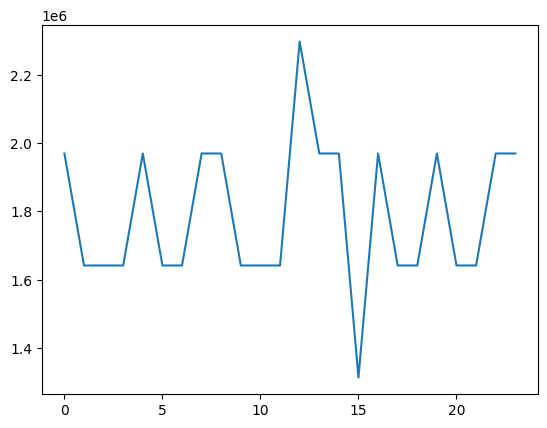

In [90]:

plt.plot(p2)

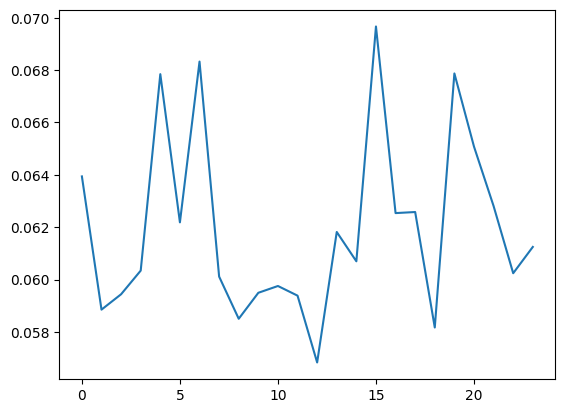

In [89]:
plt.plot(p1)